

---


# P7 - Implémentez un modèle de scoring

---
La société financière  "Prêt à dépenser"propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt. 
L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé.
**Missions**
- Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.
- Construire un dashboard interactif à destination des gestionnaires de la relation client permettant d'interpréter les prédictions faites par le modèle, et d’améliorer la connaissance client des chargés de relation client.
- Mettre en production le modèle de scoring de prédiction à l’aide d’une API, ainsi que le dashboard interactif qui appelle l’API pour les prédictions.


Dans le présent Notebook , je présente la recherche d'hyperparamètres à l'aide MLFlow et l'enregistrement du modèle dans un registe.

C:\Users\mimil\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


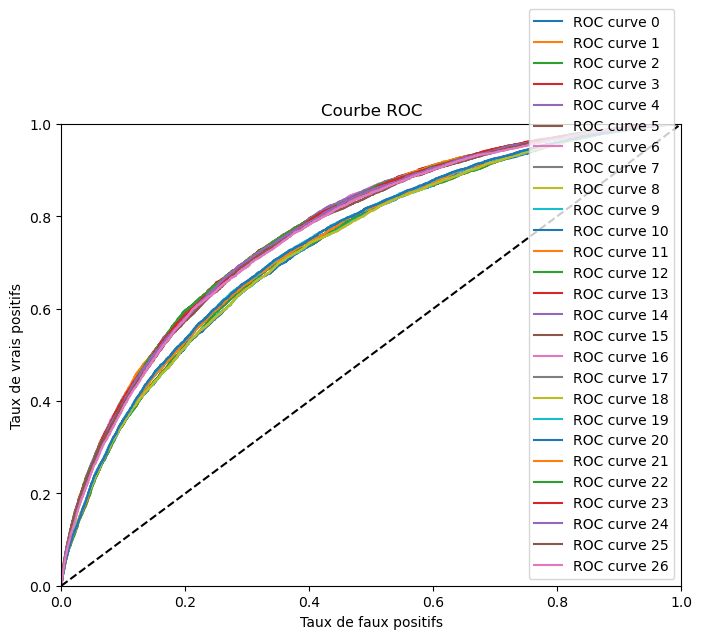

In [1]:
import mlflow.lightgbm
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
from zipfile import ZipFile
import pandas as pd
import re
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
import io
from imblearn.under_sampling import RandomUnderSampler
from sklearn import metrics

# Charger vos données

all_fpr = []
all_tpr = []
z = ZipFile("p7_test_mlflow/X_data.zip")
X_data = pd.read_csv(z.open('X_data.csv'), index_col='SK_ID_CURR', encoding='utf-8')

# Fonction pour éliminer les caractères spéciaux d'un nom de colonne
def clean_column_name(column_name):
    cleaned_name = re.sub('[^A-Za-z0-9_]+', '', column_name)
    return cleaned_name

# Renommer les colonnes en utilisant la fonction de nettoyage des noms de colonnes
X_data = X_data.rename(columns=clean_column_name)

def custom_metric(y_true, y_pred, fn_value=-100, fp_value=-10, vp_value=0, vn_value=1):
    '''
    Métrique métier tentant de minimiser le risque d'accord prêt pour la banque en pénalisant les faux négatifs.
    '''
    
    # Matrice de Confusion
    mat_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de True Negatifs
    vn = mat_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = mat_conf[1, 0]
    # Nombre de Faux Positifs
    fp = mat_conf[0, 1]
    # Nombre de True Positifs
    vp = mat_conf[1, 1]
    
    # Gain total
    J = vp * vp_value + vn * vn_value + fp * fp_value + fn * fn_value
    
    # Gain maximum
    max_J = (fp + vn) * vn_value + (fn + vp) * vp_value
    
    # Gain minimum
    min_J = (fp + vn) * fp_value + (fn + vp) * fn_value
    
    # Gain normalisé entre 0 et 1
    J_normalized = (J - min_J) / (max_J - min_J)
    
    return J_normalized  # Retourne la fonction d'évaluation

y = X_data['TARGET']
X = X_data.drop(['TARGET'], axis=1)

# Diviser les données en ensembles d'entraînement et de validation
#j'applique undersampling au jeu de données réduit
us = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = us.fit_resample(X_train, y_train)

#réquilibrage des données 

# Définir la grille des hyperparamètres à explorer
param_grid = {
    'num_leaves': [20, 30, 40],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [5, 10, -1],
}

# Initialiser MLflow
mlflow.set_tracking_uri("http://127.0.0.1:5000/")  # Remplacez par l'URI de votre serveur MLflow
mlflow.set_experiment('<P7 LGBM tracking>')  # Remplacez par le nom de votre expérience MLflow

# Effectuer une recherche d'hyperparamètres avec MLflow
best_auc = None
best_params = None
best_model = None

for num_leaves in param_grid['num_leaves']:
    for learning_rate in param_grid['learning_rate']:
        for max_depth in param_grid['max_depth']:
            model_name = "model_{}_{}_{}".format(num_leaves, learning_rate, max_depth)
            with mlflow.start_run(run_name=model_name):
                # Construire le modèle LightGBM avec les hyperparamètres actuels
                model = lgb.LGBMClassifier(
                    num_leaves=num_leaves,
                    learning_rate=learning_rate,
                    max_depth=max_depth
                )

                # Entraîner le modèle
                model.fit(X_train, y_train)

                # Prédire sur l'ensemble de validation
                y_pred = model.predict_proba(X_val)[:, 1]

                # Calculer la métrique d'évaluation (par exemple, l'aire sous la courbe ROC)
                auc = roc_auc_score(y_val, y_pred)

                # Calculer la métrique d'évaluation (par exemple notre fonction metier)
                y_pred_binary = (y_pred > 0.5).astype(int)
                score = custom_metric(y_val, y_pred_binary)

                # Calculer les taux de faux positifs, les taux de vrais positifs et les seuils à différents niveaux
                fpr, tpr, thresholds = roc_curve(y_val, y_pred)

                # Ajouter les taux de faux positifs et les taux de vrais positifs aux listes globales
                all_fpr.append(fpr)
                all_tpr.append(tpr)

                # Enregistrer les métriques et les hyperparamètres dans MLflow
                mlflow.log_param('num_leaves', num_leaves)
                mlflow.log_param('learning_rate', learning_rate)
                mlflow.log_param('max_depth', max_depth)
                mlflow.log_metric('auc', auc)
                mlflow.log_metric('score_metier', score)

                # Comparer avec le meilleur résultat précédent
                if best_auc is None or auc > best_auc:
                    best_auc = auc
                    best_params = {
                        'num_leaves': num_leaves,
                        'learning_rate': learning_rate,
                        'max_depth': max_depth
                    }
                    best_model = model

                mlflow.end_run()  # End the current run before starting a new one

with mlflow.start_run():
    mlflow.log_params(best_params)
    # Save the best model as an artifact
    mlflow.sklearn.save_model(best_model, "best_final_model2")
    mlflow.log_artifact("best_final_model2")

# Générer la courbe ROC avec l'AUC
plt.figure(figsize=(8, 6))
for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], label='ROC curve {}'.format(i))
plt.plot([0, 1], [0, 1], 'k--')  # Ligne en pointillés représentant le hasard
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Taux de faux positifs')
plt.ylabel('Taux de vrais positifs')
plt.title('Courbe ROC')
plt.legend(loc='lower right')
plt.savefig("roc_curve.png")

# Enregistrer la courbe ROC dans MLflow
with open("roc_curve.png", "rb") as f:
    binary_data = f.read()
mlflow.log_artifact("roc_curve.png", "plots")
